# 라이브러리 로드🔥

In [1]:
import pandas as pd
import requests
import time
from time import strftime
import matplotlib.pyplot as plt

# 페이지 수집 함수 작성🔥

In [2]:
def get_one_page(page_no):
    '''
    페이지 목록의 상세페이지 주소를 수집해 청원취지까지 수집하는 함수
    '''
    item_list = []
        
    # 목록 수집
    url = f'https://petitions.assembly.go.kr/api/petits?pageIndex={page_no}&recordCountPerPage=8&sort=AGRE_END_DE-&searchCondition=sj&searchKeyword=&petitRealmCode=&sttusCode=PETIT_FORMATN,CMIT_FRWRD,PETIT_END&resultCode=BFE_OTHBC_WTHDRAW,PROGRS_WTHDRAW,PETIT_UNACPT,APPRVL_END_DSUSE,ETC_TRNSF&notInColumn=RESULT_CODE&beginDate=20220101&endDate=20221231&ageCd='
    response = requests.get(url)
    
    df = pd.read_json(response.text)
    try:
        #상세페이지 수집
        petitIds = df["petitId"]

        for petitId in petitIds:
            detail_url = f'https://petitions.assembly.go.kr/api/petits/{petitId}?petitId={petitId}'
            detail_df = requests.get(detail_url).json()
            item_list.append(detail_df)

        page = pd.DataFrame(item_list)

        edit_page = page[['petitSj', 'petitObjet', 'petitCn', 'petitRealmNm', 'jrsdCmitNm', 'resultCodeNm', 'agreCo', 'agreBeginDe', 'agreEndDe']]

        edit_page = edit_page.rename(columns={
            'petitObjet' : '청원취지',
            'petitSj' : '제목', 
            'petitCn' : '내용', 
            'petitRealmNm' : '분야', 
            'jrsdCmitNm' : '담당부서', 
            'resultCodeNm' : '결과', 
            'agreBeginDe' : '동의시작일',
            'agreEndDe' : '동의종료일', 
            'agreCo': '동의수'})
        
        return edit_page
    
    except Exception as e:
        return None

In [3]:
def get_pages():
    '''
    페이지 수집 반복 함수
    '''
    page_no = 1
    pages = []

    while True:
        page = get_one_page(page_no)
        if page is None:
            break
        pages.append(page)
        page_no += 1

    time.sleep(1)
    
    df = pd.concat(pages, ignore_index=True)
    
    return df

In [4]:
start = time.time()
all_petit =get_pages()
end = time.time()

print(f"{end - start:.5f} sec")

all_petit

63.41373 sec


,제목,청원취지,내용,분야,담당부서,결과,동의수,동의시작일,동의종료일
0,"인천 미추홀구뿐만 아니라 전국적인 ‘나 홀로 아파트, 빌라’ 전세사기에 관한 청원",저는 전세사기 피해자입니다.\r\n\r\n전국적으로 발생한 전세사기 피해에 대한 현...,○ 문제점\r\n낙찰자가 생겨 곧 퇴거해야하는 피해자들을 위한 ‘전세사기피해지원센터...,국토/해양/교통,국토교통위원회,동의만료폐기,2250,2022-11-30 09:52:01,2022-12-30 23:59:59
1,"모든 학원, 상가 복도 cctv 의무화에 관한 청원",CCTV없는곳에서 일어나는 폭력을 막아주세요.,안녕하세요.\n봉담읍에 사는 초등학생 아이를 둔 엄마입니다.\n저희아이는 학원강의...,국토/해양/교통,국토교통위원회,동의만료폐기,283,2022-11-30 09:53:21,2022-12-30 23:59:59
2,간호법 제정에 관한 청원,"'간호법' 제정을 통해 간호사의 영역과 업무 범위를 명확화 하고, 간호 서비스 개선...","현재 96개국에 '간호법'이 있고, OECD 국가 38개국 중 미국을 포함한 33개...",보건의료,보건복지위원회,동의만료폐기,177,2022-11-30 09:52:59,2022-12-30 23:59:59
3,난치성 편두통 환자를 위한 CGRP 표적 치료제의 급여혜택 강화 촉구에 관한 청원,WHO에서는 세계에서 두번째로 질병 부담이 높은 질환이 편두통이라고 발표했습니다. ...,"건강보험심사평가원에서 공개한 고시 자료[1]를 보면 대상 질환의 특성으로서 ""삽화편...",보건의료,보건복지위원회,동의만료폐기,524,2022-11-28 16:39:49,2022-12-28 23:59:59
4,가상자산 위믹스 코인 거래지원종료에 관한 DAXA의 처리 투명성과 갑질논란에 관한 청원,한국거래소협회 DAXA에 의한 위믹스코인 거래지원 종료에 대한 투명성 조사와 갑질 ...,한국 거래소협회 DAXA는 10월27일 계획유통량과 실제유통량의 차이를 원인으로 삼...,재정/세제/금융/예산,정무위원회,동의만료폐기,6165,2022-11-28 16:40:33,2022-12-28 23:59:59
...,...,...,...,...,...,...,...,...,...
334,양승태 전 대법원장 재임기간 중의 사법농단 의혹사건 피해자 구제를 위한 특별법안 제...,양승태 전 대법원장 체제하에서의 대법원이 상고 법원 설치 등 특정 목적을 관철 시...,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다.\n1. “사법농단피해자...,수사/법무/사법제도,법제사법위원회,동의만료폐기,429,2021-12-13 17:47:48,2022-01-12 23:59:59
335,n번방 방지법인 전기통신사업법 개정안의 재개정에 관한 청원,"헌법 제 18조를 위배하며, 법의 효율성이 의심되는 해당 개정안에 대한 개정을 바람","먼저, 해당 개정안은 헌법 제18조를 위배할 우려가 큽니다. ""모든 국민은 통신의 ...",과학기술/정보통신,과학기술정보방송통신위원회,동의만료폐기,1853,2021-12-13 17:49:00,2022-01-12 23:59:59
336,수개표로 전환 안심 선거에 관한 청원,안녕하십니까? \n\n공직선거에서 전자개표가 도입된 이래 끊임없이 부정선거의 논란이...,1. ‘당일 투표’를 기본 원칙으로 한다.\n\n부정선거의 가능성이 높은 사전투표와...,정치/선거/국회운영,행정안전위원회,동의만료폐기,3034,2021-12-07 16:21:09,2022-01-06 23:59:59
337,발달재활서비스 제공 인력의 생존권을 위한 자격 인정 제도 개선에 관한 청원,"수많은 치료사 ,선생님들 지금거리로 몰리고있습니다 도와주세요...",\n발달재활서비스 제공인력 인증 강화 심사에 대해 청원합니다.\n\n안녕하세요. 경...,복지/보훈,보건복지위원회,동의만료폐기,210,2021-12-07 16:22:35,2022-01-06 23:59:59


# 파일로 저장🔥

In [5]:
file_name = 'data/agreeEnded_petit_' + strftime('%Y-%m-%d') + '.csv'
all_petit.to_csv(file_name, index=False)

In [6]:
print(file_name)
pd.read_csv(file_name)

data/agreeEnded_petit_2023-01-25.csv


,제목,청원취지,내용,분야,담당부서,결과,동의수,동의시작일,동의종료일
0,"인천 미추홀구뿐만 아니라 전국적인 ‘나 홀로 아파트, 빌라’ 전세사기에 관한 청원",저는 전세사기 피해자입니다.\r\n\r\n전국적으로 발생한 전세사기 피해에 대한 현...,○ 문제점\r\n낙찰자가 생겨 곧 퇴거해야하는 피해자들을 위한 ‘전세사기피해지원센터...,국토/해양/교통,국토교통위원회,동의만료폐기,2250,2022-11-30 09:52:01,2022-12-30 23:59:59
1,"모든 학원, 상가 복도 cctv 의무화에 관한 청원",CCTV없는곳에서 일어나는 폭력을 막아주세요.,안녕하세요.\n봉담읍에 사는 초등학생 아이를 둔 엄마입니다.\n저희아이는 학원강의...,국토/해양/교통,국토교통위원회,동의만료폐기,283,2022-11-30 09:53:21,2022-12-30 23:59:59
2,간호법 제정에 관한 청원,"'간호법' 제정을 통해 간호사의 영역과 업무 범위를 명확화 하고, 간호 서비스 개선...","현재 96개국에 '간호법'이 있고, OECD 국가 38개국 중 미국을 포함한 33개...",보건의료,보건복지위원회,동의만료폐기,177,2022-11-30 09:52:59,2022-12-30 23:59:59
3,난치성 편두통 환자를 위한 CGRP 표적 치료제의 급여혜택 강화 촉구에 관한 청원,WHO에서는 세계에서 두번째로 질병 부담이 높은 질환이 편두통이라고 발표했습니다. ...,"건강보험심사평가원에서 공개한 고시 자료[1]를 보면 대상 질환의 특성으로서 ""삽화편...",보건의료,보건복지위원회,동의만료폐기,524,2022-11-28 16:39:49,2022-12-28 23:59:59
4,가상자산 위믹스 코인 거래지원종료에 관한 DAXA의 처리 투명성과 갑질논란에 관한 청원,한국거래소협회 DAXA에 의한 위믹스코인 거래지원 종료에 대한 투명성 조사와 갑질 ...,한국 거래소협회 DAXA는 10월27일 계획유통량과 실제유통량의 차이를 원인으로 삼...,재정/세제/금융/예산,정무위원회,동의만료폐기,6165,2022-11-28 16:40:33,2022-12-28 23:59:59
...,...,...,...,...,...,...,...,...,...
334,양승태 전 대법원장 재임기간 중의 사법농단 의혹사건 피해자 구제를 위한 특별법안 제...,양승태 전 대법원장 체제하에서의 대법원이 상고 법원 설치 등 특정 목적을 관철 시...,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다.\n1. “사법농단피해자...,수사/법무/사법제도,법제사법위원회,동의만료폐기,429,2021-12-13 17:47:48,2022-01-12 23:59:59
335,n번방 방지법인 전기통신사업법 개정안의 재개정에 관한 청원,"헌법 제 18조를 위배하며, 법의 효율성이 의심되는 해당 개정안에 대한 개정을 바람","먼저, 해당 개정안은 헌법 제18조를 위배할 우려가 큽니다. ""모든 국민은 통신의 ...",과학기술/정보통신,과학기술정보방송통신위원회,동의만료폐기,1853,2021-12-13 17:49:00,2022-01-12 23:59:59
336,수개표로 전환 안심 선거에 관한 청원,안녕하십니까? \n\n공직선거에서 전자개표가 도입된 이래 끊임없이 부정선거의 논란이...,1. ‘당일 투표’를 기본 원칙으로 한다.\n\n부정선거의 가능성이 높은 사전투표와...,정치/선거/국회운영,행정안전위원회,동의만료폐기,3034,2021-12-07 16:21:09,2022-01-06 23:59:59
337,발달재활서비스 제공 인력의 생존권을 위한 자격 인정 제도 개선에 관한 청원,"수많은 치료사 ,선생님들 지금거리로 몰리고있습니다 도와주세요...",\n발달재활서비스 제공인력 인증 강화 심사에 대해 청원합니다.\n\n안녕하세요. 경...,복지/보훈,보건복지위원회,동의만료폐기,210,2021-12-07 16:22:35,2022-01-06 23:59:59


중복 확인 및 중복 제거 과정

In [ ]:
# # 중복항목 확인 > 총 3가지 청원이 중복 청원 되어있는 것이 확인됨
# dp_petit = all_petit[all_petit.duplicated(keep = False, subset = ['제목'])]
# dp_petit 

In [ ]:
# # 중복청원별 동의수 순으로 정렬한 뒤, 가장 동의 수가 많은 하나를 제외한 중복데이터 제거
# dp_sort = dp_petit.sort_values(['제목', '동의수'], ascending = False)
# dp_del = dp_sort.drop_duplicates(subset = ['제목'])

# 중복 제거 🔥

In [7]:
petit_sort = all_petit.sort_values(['제목', '동의수'], ascending = False)
dp_del = petit_sort.drop_duplicates(subset = ['제목'])
dp_del = dp_del.drop_duplicates(subset = ['청원취지']) # 범주 기술통계 보니 제목이 미세하게 다르지만, 취지가 같은게 4개였음
dp_del

,제목,청원취지,내용,분야,담당부서,결과,동의수,동의시작일,동의종료일
158,흉악범 사형집행을 요청합니다에 관한 청원,사형제도 특별법을 만들어서 사형집행을 해주셨으면 좋겠습니다\r\n사회에서 완전히 격...,"아무리 흉포한 죄를 지었더라도 사형선고는 커녕 무기징역에 그치는 경우가 많으며, 설...",수사/법무/사법제도,법제사법위원회,동의만료폐기,336,2022-07-26 18:14:34,2022-08-25 23:59:59
43,환전사기범들 꼭잡아주세요에 관한 청원,보이스 피싱과 유사한 사기임에도 불구하고 아무런 법안이 마련되어 있지 않아서 피해자...,보이스 피싱과 유사하면서도 더 악랄하게 사기꾼들은 피해자의 믿음을 사기 위해 접근한...,소비자/공정거래,정무위원회,동의만료폐기,218,2022-11-01 20:43:47,2022-12-01 23:59:59
153,화성연쇄살인 몽타주 도용으로 반 묻지마 제보 법과 반 묻지마 대처 법 제정을 청원합...,화성연쇄살인 이춘재 옆 얼굴 몽타주는 1988년 9월 저의 얼굴 사진을 도용해 만들...,화성연쇄살인 이춘재 옆 얼굴 몽타주는 1988년 9월 10일 만든 것으로 저의 얼굴...,수사/법무/사법제도,법제사법위원회,동의만료폐기,125,2022-07-26 18:14:21,2022-08-25 23:59:59
72,형사소송법 제70조 구속의 사유에 피해자 보호를 위한 사유 추가에 관한 청원,현재 스토킹범죄로 인하여 무고한 생명이 죽어가고 있습니다. 구속영장이 도주우려가 없...,현재 신당역 살인 사건을 포함하여 '여친을 2분 간격 10시간 전화해 스토킹...결...,수사/법무/사법제도,법제사법위원회,동의만료폐기,204,2022-10-12 15:55:00,2022-11-11 23:59:59
131,해운대 관광컨셉시설 이행 촉구에 관한 청원,해운대 관광컨셉시설은 시민과의 약속입니다,부산 해운대 엘시티 분양 당시 상가 몰에 관광컨셉시설이 들어온다고 했습니다. \r\...,문화/체육/관광/언론,문화체육관광위원회,동의만료폐기,303,2022-08-09 17:04:09,2022-09-08 23:59:59
...,...,...,...,...,...,...,...,...,...
47,10년째 동결된 가정양육수당 인상 요구에 관한 청원,▶ 2013년부터 정부가 전계층 무상보육 정책을 시행하였음. 그런데 2022년 기준...,"▶ 만 2세 아이를 기준으로 어린이집에서 다니는 아이들은 기본보육료 364,000 ...",복지/보훈,보건복지위원회,동의만료폐기,2978,2022-10-31 16:59:19,2022-11-30 23:59:59
48,10년공공임대아파트 관련 공공주택특별법 개정법률안 조속 통과에 관한 청원,"공공주택특별법 일부개정법률안(대표발의 의원님: 김상희, 김회재, 김은혜, \r\n박...",【청원의 이유 및 내용】\r\n\r\n1. 5년공공임대주택과 10년공공임대주택이 기...,국토/해양/교통,국토교통위원회,동의만료폐기,140,2022-10-31 16:59:48,2022-11-30 23:59:59
45,"1,400만명 개인주주를 절망에 빠트리고 건전한 자본시장을 좀먹는 공매도의 한시적 ...",1) 본 청원은 우리 증시를 글로벌 증시 대비 과도하게 하락한 상황이 정상화될 때까...,현재 우리나라 증시는 공매도 세력들의 놀이터가 되어버렸습니다. 우리나라 공매도 거래...,재정/세제/금융/예산,정무위원회,동의만료폐기,28405,2022-10-31 17:00:18,2022-11-30 23:59:59
289,"""2020년에 동물학대범 1014명이 검거됐으며 1명이 구속됐다"" 동물보호법을 강화...",동물보호법 개정과 강화,또 “지난 10년간 전국적으로 약 4400명의 동물보호법 위반 사범 중 고작 구속된...,농업/임업/수산업/축산업,농림축산식품해양수산위원회,동의만료폐기,2077,2022-05-10 17:29:55,2022-06-10 23:59:59


# 데이터 처리

In [8]:
data_set = dp_del

In [ ]:
# # 그냥.. 이거저거 봐 보기
# data_set.sort_values('동의수', ascending = False)
# data_set.describe()
# data_set.describe(include='O')

In [9]:
# 그래프 한글 깨짐 해결
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

## 분야별 청원 개수

In [10]:
# 분야별 청원 결과
bar_table = pd.crosstab(data_set['분야'],data_set['결과'])
bar_table

결과,동의만료폐기,본회의불부의,위원회심사,위원회접수후철회
분야,,,,
과학기술/정보통신,8,1,0,0
교육,24,0,0,0
국토/해양/교통,40,0,0,0
기타,12,0,0,0
농업/임업/수산업/축산업,13,0,1,0
문화/체육/관광/언론,11,0,1,0
보건의료,49,0,4,0
복지/보훈,10,0,0,0
산업/통상,19,0,3,0


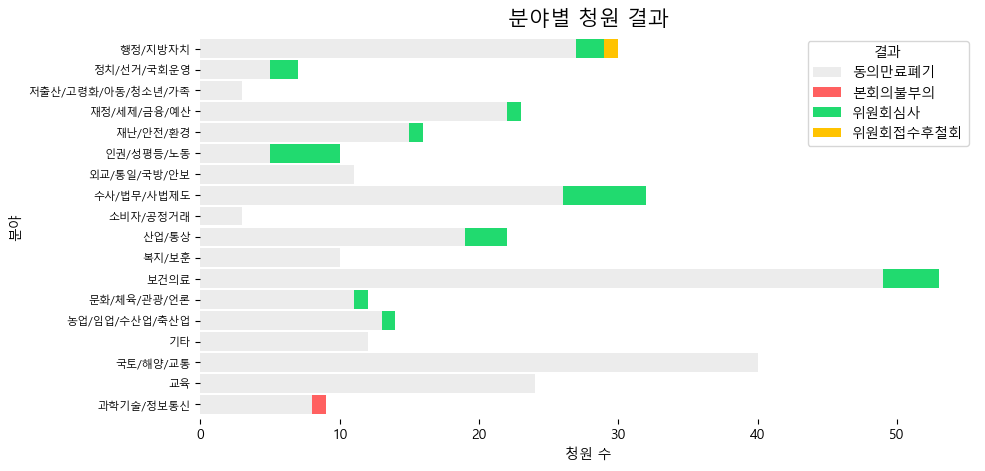

In [11]:
# 분야명이 길어서 수직은 보기 불편하길래 눕혀버림ㅎㅎ..
bar_table.plot.barh(rot=0, stacked=True, figsize=(10, 5), width=0.9,
                    color={'동의만료폐기': '#ECECEC', '본회의불부의': '#FF6060', '위원회심사': '#21DA6F', '위원회접수후철회': '#FFC300'})
plt.title('분야별 청원 결과', fontsize = 15)
plt.xlabel('청원 수', fontsize=10)
plt.yticks(fontsize=8)
plt.box(False)
plt.show()

## 성립청원

### 성립청원 기본 정보

In [12]:
success = data_set.loc[data_set['동의수'] >= 50000]
success = success.sort_values('동의종료일',  ignore_index = True)
success.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제목      28 non-null     object
 1   청원취지    28 non-null     object
 2   내용      28 non-null     object
 3   분야      28 non-null     object
 4   담당부서    28 non-null     object
 5   결과      28 non-null     object
 6   동의수     28 non-null     int64 
 7   동의시작일   28 non-null     object
 8   동의종료일   28 non-null     object
dtypes: int64(1), object(8)
memory usage: 2.1+ KB


### 성립청원 동의 기간

In [13]:
start_day = pd.to_datetime(success['동의시작일'])
end_day = pd.to_datetime(success['동의종료일'])

success['동의기간'] = end_day -  start_day
success.sort_values('동의기간').head(5)

,제목,청원취지,내용,분야,담당부서,결과,동의수,동의시작일,동의종료일,동의기간
8,전력 판매 시장 민간 개방 반대를 위한 전기사업법 개정에 관한 청원,"오늘날 현대 문명 사회에서 전기는 물과 공기와 같습니다. 수도, 의료, 가스, 통신...",현재 대통령직 인수위원회는 한국전력공사 전력판매 독점 폐지를 추진하겠다고 공약하였습...,산업/통상,산업통상자원중소벤처기업위원회,위원회심사,50000,2022-05-02 18:11:55,2022-05-04 09:27:14,1 days 15:15:19
20,공무원연금 소득공백 해소 및 온전한 퇴직금 보장에 관한 청원,공무원연금법의 정년과 연금수급 시기 불일치로 인한 소득공백이 발생한 문제점을 해소하...,1. 공무원연금법 제43조(퇴직연금 또는 퇴직연금일시금 등) 제1항 개정 \n - ...,행정/지방자치,행정안전위원회,위원회심사,50000,2022-10-18 09:07:42,2022-10-20 08:22:20,1 days 23:14:38
11,여성가족부 폐지 찬성 및 동의에 관한 청원,"국민 세금으로 성별 갈등을 조장하고, 특정 이념(페미니즘)을 국민에게 주입하며, 여...",<여성가족부가 해체되어야 하는 7가지 이유>\n(글자수 제한으로 인하여 상세이유를 ...,행정/지방자치,행정안전위원회,위원회심사,50000,2022-05-18 18:28:50,2022-05-22 11:31:51,3 days 17:03:01
23,이태원 사고 관련 상황의 세금 사용에 관한 법률 개정에 관한 청원,"이태원 사고는 그 유가족에게는 슬프고, 참사라고 할 수 있겠으나 이런 대규모 인원의...",이태원 사고의 경우 정부에서 장례비용과 치료비용을 지원한다는 기사를 접하고 나의 세...,재난/안전/환경,행정안전위원회,위원회심사,50000,2022-10-31 17:00:50,2022-11-06 11:13:01,5 days 18:12:11
19,"온라인, 패키지, 콘솔, 모바일 등 게임물에 대한 사전심의의무 폐지에 관한 청원",헌법 제21조 ①모든 국민은 언론ㆍ출판의 자유와 집회ㆍ결사의 자유를 가진다.\r\n...,2005년 바다이야기 사태 이후 출범한 게임물등급위원회→현 게임물관리위원회는 출범 ...,문화/체육/관광/언론,문화체육관광위원회,위원회심사,50000,2022-10-07 17:49:14,2022-10-13 20:39:24,6 days 02:50:10


In [ ]:
# # 넘파이로 평균 구하기도 가능!
# import numpy
# str(numpy.mean(success['동의기간']))

In [14]:
success.describe()

,동의수,동의기간
count,28.000000,28
mean,51785.714286,21 days 02:49:03.892857142
std,9449.111825,10 days 13:50:49.714416631
min,50000.000000,1 days 15:15:19
25%,50000.000000,12 days 13:39:04.250000
50%,50000.000000,26 days 20:14:52
75%,50000.000000,29 days 06:49:10.250000
max,100000.000000,36 days 01:46:42


## 📋 짧은 시간 내에 동의인원을 모은 청원 TOP 5

1. 전력 판매 시장 민간 개방 반대를 위한 전기사업법 개정에 관한 청원 / 1 days 15:15:19
2. 공무원연금 소득공백 해소 및 온전한 퇴직금 보장에 관한 청원 / 1 days 23:14:38
3. 여성가족부 폐지 찬성 및 동의에 관한 청원 / 3 days 17:03:01
4. 이태원 사고 관련 상황의 세금 사용에 관한 법률 개정에 관한 청원 / 5 days 18:12:11
5. 온라인, 패키지, 콘솔, 모바일 등 게임물에 대한 사전심의의무 폐지에 관한 청원 / 6 days 02:50:10

## 미성립청원

In [15]:
fail = data_set.loc[data_set['동의수'] < 50000]
fail = fail.sort_values('동의수', ascending = False, ignore_index = True)
fail

,제목,청원취지,내용,분야,담당부서,결과,동의수,동의시작일,동의종료일
0,"구멍 뚫린 GMO수입검역체계 OUT, 유전자변형생물체의국가간이동등에관한법률의 개정에...",▶전 세계 약 180개 국가는 GMO의 인체 ·환경 피해를 사전방지하기 위해 공동의...,1996년 GMO가 처음 상업화된 후 30년 가까운 시간이 흘렀어도 논쟁이 계속되고...,산업/통상,산업통상자원중소벤처기업위원회,동의만료폐기,35303,2022-09-23 14:07:08,2022-10-23 23:59:59
1,양승태 전 대법원장 재임기간 중의 사법농단 의혹사건 피해자 구제를 위한 특별법안 제...,양승태 전 대법원장 체제하에서의 대법원이 상고 법원 설치 등 특정 목적을 관철 시...,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다.\n1. “사법농단피해자...,수사/법무/사법제도,법제사법위원회,동의만료폐기,34004,2022-04-20 17:34:56,2022-05-20 23:59:59
2,"1,400만명 개인주주를 절망에 빠트리고 건전한 자본시장을 좀먹는 공매도의 한시적 ...",1) 본 청원은 우리 증시를 글로벌 증시 대비 과도하게 하락한 상황이 정상화될 때까...,현재 우리나라 증시는 공매도 세력들의 놀이터가 되어버렸습니다. 우리나라 공매도 거래...,재정/세제/금융/예산,정무위원회,동의만료폐기,28405,2022-10-31 17:00:18,2022-11-30 23:59:59
3,코로나 백신 특검 요청에 관한 청원,"너무나도 많은 국민이 백신 부작용으로 큰 피해를 보고 있고, 정작 최선의 대안은 백...",에코헬스 얼라이언스(EcoHealth Alliance)의 회장 피터 다작(Peter...,수사/법무/사법제도,법제사법위원회,동의만료폐기,27092,2021-12-21 09:41:41,2022-01-20 23:59:59
4,촉법소년인 학교폭력 및 성폭행 가해자들의 엄중 처벌에 관한 청원,촉법소년 이란 이유로 너무나도 큰 죄를 지었음에 불구하고 처벌이 되지 않는다는것은 ...,조카가 초등학교 3학년입니다 동급생 친구와\r\n같은학교 6학년 형들에게 꾸준한 학...,수사/법무/사법제도,법제사법위원회,동의만료폐기,26796,2022-06-15 15:26:23,2022-07-15 23:59:59
...,...,...,...,...,...,...,...,...,...
298,출산장려정책에 관한 청원,"출산기피현상이 만연하여, 사회문제 나아가 국가존립의 문제이기에 ,아래와 같은 의견...","2021년도 신생아 출생아는 270,000명으로 , OECD 국가중 최하위인데 ...",행정/지방자치,행정안전위원회,동의만료폐기,120,2022-09-02 18:11:50,2022-10-02 23:59:59
299,동탄우남퍼스트빌테라스 위험군 하자보수 불이행 건에 관한 청원,작년 9월 완공되어 거주중인 아파트 하자중 위험군에 속하는 외벽 부서짐과 2층 계단...,[2021년 9월 완공된 현거주중인 동탄우남퍼스트빌더테라스(동탄호수우남더테라스) 하...,국토/해양/교통,국토교통위원회,동의만료폐기,116,2022-07-19 17:57:34,2022-08-18 23:59:59
300,부천 지하실 침수피해에 관한 청원,신축 건물로 인해 지하실 피해을 한달데 5번 이나 침수 됐는데 부천시청에서는 민...,부천시장님 안녕하십니까? \r\n 당사는 (주) 씨디 종합건설이 신축중인 건물 아...,국토/해양/교통,국토교통위원회,동의만료폐기,115,2022-09-29 17:44:44,2022-10-29 23:59:59
301,세마역 주변 소음 방지를 위한 해결 방안 요청 건.에 관한 청원,세마역 주변에 지하철 및 기차등으로 인해 소음이 심합니다. 이에 철도공사측은 주변 ...,세마역 근처 건물에 직장인 입니다. 전철역이 있어 출퇴근 하는 편리 합니다. \r\...,국토/해양/교통,국토교통위원회,동의만료폐기,114,2022-07-26 18:14:06,2022-08-25 23:59:59


In [17]:
# 미성립청원 동의수 top5
fail.sort_values('동의수', ascending = False, ignore_index = True).head(5)

,제목,청원취지,내용,분야,담당부서,결과,동의수,동의시작일,동의종료일
0,"구멍 뚫린 GMO수입검역체계 OUT, 유전자변형생물체의국가간이동등에관한법률의 개정에...",▶전 세계 약 180개 국가는 GMO의 인체 ·환경 피해를 사전방지하기 위해 공동의...,1996년 GMO가 처음 상업화된 후 30년 가까운 시간이 흘렀어도 논쟁이 계속되고...,산업/통상,산업통상자원중소벤처기업위원회,동의만료폐기,35303,2022-09-23 14:07:08,2022-10-23 23:59:59
1,양승태 전 대법원장 재임기간 중의 사법농단 의혹사건 피해자 구제를 위한 특별법안 제...,양승태 전 대법원장 체제하에서의 대법원이 상고 법원 설치 등 특정 목적을 관철 시...,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다.\n1. “사법농단피해자...,수사/법무/사법제도,법제사법위원회,동의만료폐기,34004,2022-04-20 17:34:56,2022-05-20 23:59:59
2,"1,400만명 개인주주를 절망에 빠트리고 건전한 자본시장을 좀먹는 공매도의 한시적 ...",1) 본 청원은 우리 증시를 글로벌 증시 대비 과도하게 하락한 상황이 정상화될 때까...,현재 우리나라 증시는 공매도 세력들의 놀이터가 되어버렸습니다. 우리나라 공매도 거래...,재정/세제/금융/예산,정무위원회,동의만료폐기,28405,2022-10-31 17:00:18,2022-11-30 23:59:59
3,코로나 백신 특검 요청에 관한 청원,"너무나도 많은 국민이 백신 부작용으로 큰 피해를 보고 있고, 정작 최선의 대안은 백...",에코헬스 얼라이언스(EcoHealth Alliance)의 회장 피터 다작(Peter...,수사/법무/사법제도,법제사법위원회,동의만료폐기,27092,2021-12-21 09:41:41,2022-01-20 23:59:59
4,촉법소년인 학교폭력 및 성폭행 가해자들의 엄중 처벌에 관한 청원,촉법소년 이란 이유로 너무나도 큰 죄를 지었음에 불구하고 처벌이 되지 않는다는것은 ...,조카가 초등학교 3학년입니다 동급생 친구와\r\n같은학교 6학년 형들에게 꾸준한 학...,수사/법무/사법제도,법제사법위원회,동의만료폐기,26796,2022-06-15 15:26:23,2022-07-15 23:59:59
